In [18]:
%run Dataset.py
%run preprocessors.py
%run Speech.py    
%run DataLoader.py
%run radar.py
%run polarity_graph.py
import os
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn import metrics
from preprocessors import *
from sklearn.metrics import *
from datetime import datetime
import matplotlib.pyplot as plt
from Dataset import SpeechDataset
from DataLoader import DataLoader
from xgboost import XGBClassifier
from sklearn.preprocessing import *
from matplotlib.pyplot import figure
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [114]:
cwd = os.getcwd()
#dataset_types = ["important", "typical"]
dataset_types = ["important"]
resources_dir = f"{cwd}/resources"
saving_dir = f"{cwd}/resources/dataset_all.csv"
sentiment_blob_speech = f"{cwd}/resources/sentiment_blob_speech.csv"

# Dataset Creation and Extraction of Importance Measures

In [115]:
#path=r"D:/OneDrive - Escuela Superior Politécnica del Litoral/KULEUVEN/TERM2/MODER DATA ANALYTICS/Project/mda_project_what_makes_a_great_speech/resources/"
sentiment_blob_speech= pd.read_csv(sentiment_blob_speech)
df= pd.read_csv(saving_dir)
df['label'] = df['label'].astype('str') 
df["label"].str.strip()
df["label"].replace({"1.0": "Great Speech", "0.0": "Typical Speech"}, inplace=True)
df=df.rename(columns = {'Unnamed: 0':'speech_number'})

#merge polarity per section and emotions df.
#reshape sentiment_blob_speech
blob=sentiment_blob_speech.iloc[:, [1,2,3,4]]
w_blob_speech=blob.pivot( index=["speech_number"], columns="position", values="sentiment_blob").reset_index()
w_blob_speech= w_blob_speech.add_prefix('pos_')
w_blob_speech=w_blob_speech.rename(columns = {'pos_speech_number':'speech_number'})
combined=df.merge(w_blob_speech, on="speech_number")
combined.head()


,speech_number,speaker,title,year,content,anger,disgust,fear,joy,neutral,...,pos_0,pos_1,pos_2,pos_3,pos_4,pos_5,pos_6,pos_7,pos_8,pos_9
0,0,Margaret Chase Smith,Declaration of Conscience,1950,\n \n Mr. President \n I would like to speak ...,0.047322,0.003706,0.912352,0.003271,0.010554,...,0.000000,0.102500,0.233750,-0.062350,-0.002041,0.017308,0.088462,0.087500,0.244444,0.039728
1,1,Richard M. Nixon,Checkers Speech,1952,\n \n \n My Fellow Americans \n \n I come bef...,0.328883,0.139531,0.349103,0.014969,0.123523,...,-0.098095,0.142231,0.283461,0.119397,0.025362,0.202106,0.110648,0.048701,0.096046,0.525000
2,2,Franklin D. Roosevelt,Pearl Harbor Address to the Nation,1941,\n \n \n Mr. Vice President Mr. Speaker Membe...,0.077378,0.027971,0.708233,0.016786,0.043711,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015325
3,3,Franklin Delano Roosevelt,The Four Freedoms,1941,\n \n \n \n Mr. President Mr. Speaker members...,0.005484,0.001582,0.978207,0.002204,0.006678,...,0.119336,0.046430,0.044093,-0.014103,0.287330,0.125000,0.246895,0.226638,0.176845,0.204282
4,4,Geraldine Ferraro,Vice Presidential Nomination Acceptance Address,1984,\n \n \n Ladies and gentlemen of the conventi...,0.064974,0.030139,0.243491,0.443653,0.184664,...,0.356250,0.235404,0.115000,0.165210,0.164286,0.314286,0.200458,0.244877,0.216667,0.040476


# Descriptives and visualizacion analysis

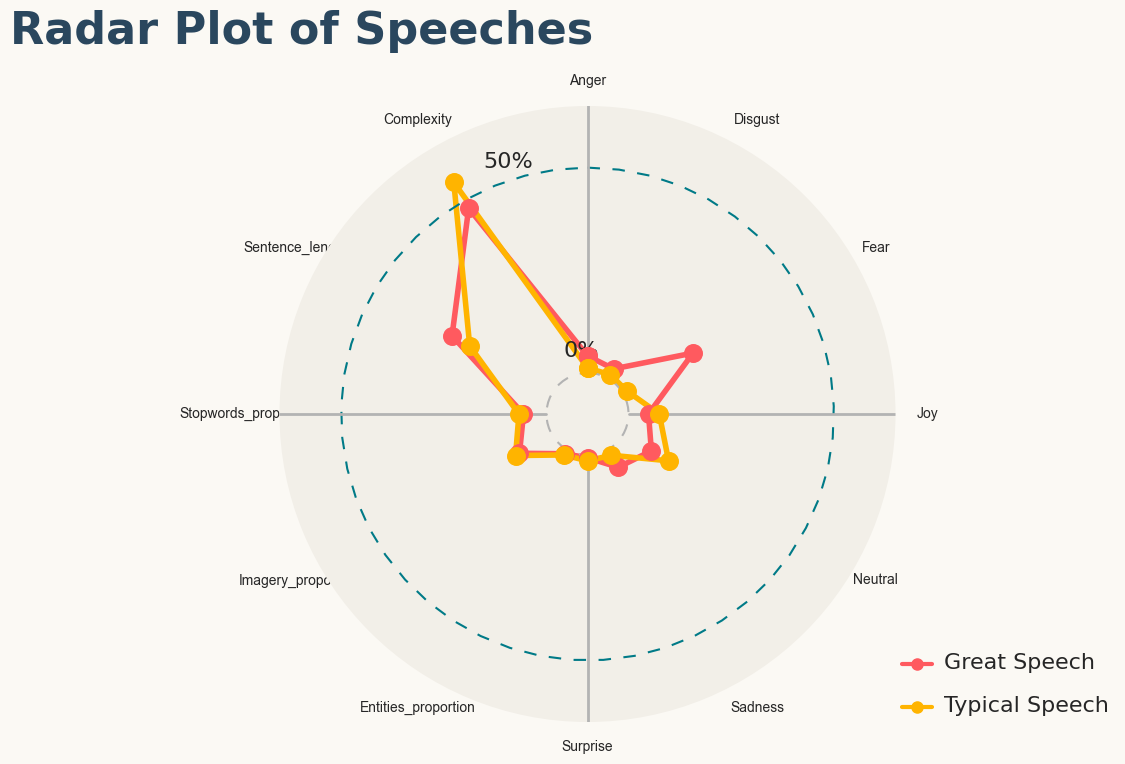

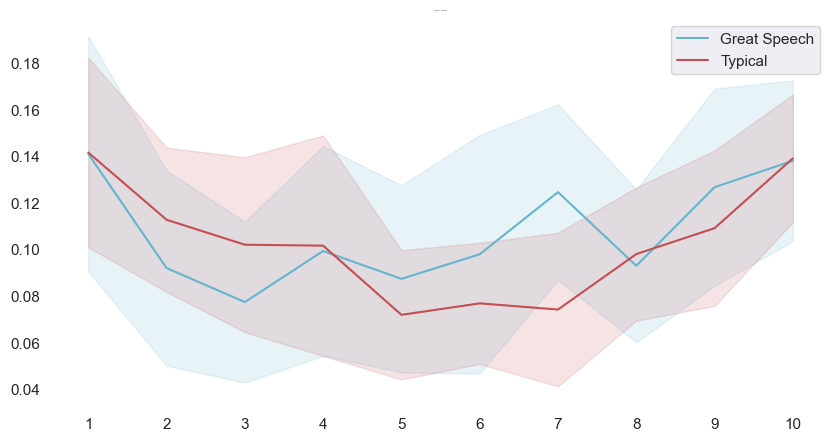

In [19]:
# rador
radar(df)
plot_speech_position(sentiment_blob_speech)  
#anger 🤬 


# Correlation Analysis of features

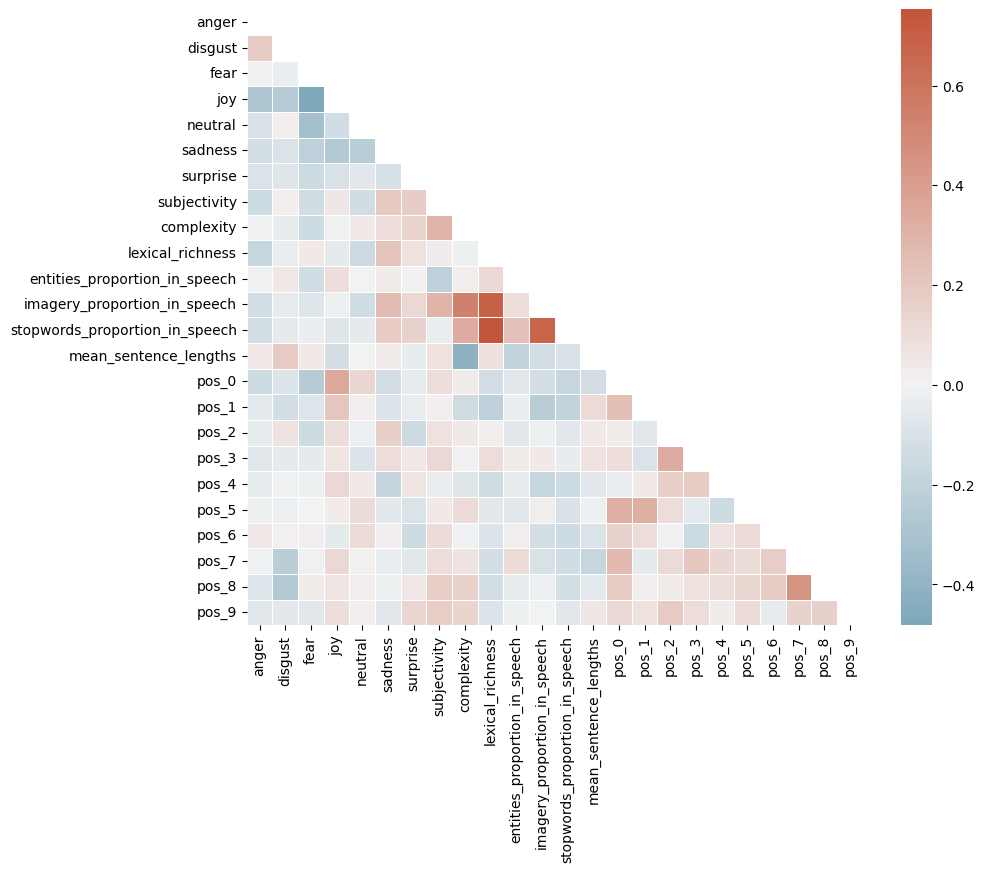

In [99]:
data = combined.iloc[:, 5:]
data=data.loc[:, data.columns!='label']
data=data.loc[:, data.columns!='polarity']
feature_names=data.columns

correlation_d = data.corr()
mask = np.triu(np.ones_like(correlation_d, dtype=bool))
f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_d, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5)

corr_abs = correlation_d.abs()
unstacked_v = corr_abs.unstack()
sort_v = pd.DataFrame(unstacked_v.sort_values(kind='quicksort'), columns=['correlation'])

# Classification
## Logistic Regression, Support Vectors, Random Forest (Bagging approach), and Extreme Gradient (Boosting approach)

In [ ]:
grid_param_dict = {}

param_grid_XGBoost = {"XGBoost": [{
    'encoder': [StandardScaler(), RobustScaler()],
    "clf__learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "clf__max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "clf__min_child_weight": [1, 3, 5, 7],
    "clf__gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "clf__colsample_bytree": [0.3, 0.4, 0.5, 0.7]}]}
param_grid_SVC = {"svm": [{
    'encoder': [StandardScaler(), RobustScaler()],
    'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'clf__gamma': [100, 10, 1, 0.1, 0.2, 0.02, 0.002, 0.0002, 0.01, 0.001, 0.0001],
    'clf__kernel': ['rbf', 'linear']}]}
param_grid_LR = {"logistic": [{
    'encoder': [StandardScaler(), RobustScaler()],
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.001, 0.01, 0.1, 1],
    'clf__solver': ['liblinear']}]}
param_grid_RF = {"RandomForest": [{
    'encoder': [StandardScaler(), RobustScaler()],
    'clf__min_samples_leaf': [1, 2, 3, 4, 5 ],
    'clf__max_depth': [1, 2, 3, 4, 5],
    'clf__min_samples_split': [1, 2, 3, 4, 5]}]}

grid_param_dict.update(param_grid_SVC)
grid_param_dict.update(param_grid_LR)
grid_param_dict.update(param_grid_RF)
grid_param_dict.update(param_grid_XGBoost)

saving_dir = f"{cwd}/results/MLA_compare.csv"
combined["label"].replace({"Great Speech": 1,"Typical Speech": 0 }, inplace=True)
#combined = combined.sample(frac=0.25)
data = combined.iloc[:, 5:]
data=data.loc[:, data.columns!='label']
data=np.array(data.loc[:, data.columns!='polarity'])
target = np.array(combined['label'])
#data = np.array(df.iloc[:, 5:-1])
#target = np.array(df.iloc[:, -1])

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3,
                                                    stratify=target, random_state=109)
model_dict = {
    'logistic': LogisticRegression(random_state=11, max_iter=10000),
    'svm': svm.SVC(probability=True),
    'RandomForest': RandomForestClassifier(verbose=True, n_estimators=500),
    'XGBoost': XGBClassifier(verbose=True),
}

classification_comparison_columns = []
classification_comparison_columns = pd.DataFrame(columns=classification_comparison_columns)
results = []

cv = KFold(n_splits=5, shuffle=True, random_state=1)
for i, model in enumerate(model_dict.keys()):
    print(model)
    start = datetime.now()
    pipe = Pipeline(steps=[('encoder', "passthrough"), ("reduce_dim", "passthrough"), 
                           ('clf', model_dict[model])])

    grid = GridSearchCV(pipe, n_jobs=-1, param_grid=grid_param_dict[model],
                        cv=cv, scoring='accuracy', refit=True, verbose=0)
    grid.fit(X_train, y_train)
    end = datetime.now()

    y_pred = grid.predict(X_test)
    y_train_pred = grid.predict(X_train)
    y_train_pred_scores = grid.predict_proba(X_train)[:, 1]
    y_test_pred_scores = grid.predict_proba(X_test)[:, 1]

    roc_train = roc_auc_score(y_train, y_train_pred_scores)
    accuracy_train = metrics.accuracy_score(y_train, y_train_pred)
    roc_test = roc_auc_score(y_test, y_test_pred_scores)
    ac_test = metrics.accuracy_score(y_test, y_pred)

    MLA_name = model_dict[model].__class__.__name__
    classification_comparison_columns.loc[i, 'Name'] = MLA_name
    classification_comparison_columns.loc[i, 'Tuned Hyperparameters'] = str(grid.best_params_)
    classification_comparison_columns.loc[i, 'Train_Accuracy'] = accuracy_train
    classification_comparison_columns.loc[i, 'Test_Accuracy'] = round(ac_test, 4)
    classification_comparison_columns.loc[i, 'Tran_ROC'] = round(roc_train, 4)
    classification_comparison_columns.loc[i, 'Test_ROC'] = round(roc_test, 4)
    classification_comparison_columns.loc[i, 'duration_minutes'] = (end - start).total_seconds() / 60
classification_comparison_columns.to_csv(saving_dir, sep=',', index=False)
classification_comparison_columns['Tuned Hyperparameters']

In [118]:
saving_dir = f"{cwd}/results/MLA_compare.csv"
model_results= pd.read_csv(saving_dir)
model_results.head()

,Name,Tuned Hyperparameters,Train_precision,Test_Presicion,Precision difference,Tran_ROC,Test_ROC,Roc diff,duration_minutes
0,RandomForestClassifier,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",78.35%,76.60%,-1.75%,99.58%,82.43%,-17.15%,32.506144
1,XGBClassifier,"{'clf__colsample_bytree': 0.7, 'clf__gamma': 0...",79.35%,72.34%,-7.01%,99.37%,79.35%,-20.02%,13.150836
2,LogisticRegression,"{'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__so...",68.18%,78.72%,10.54%,83.65%,78.08%,-5.57%,0.002261
3,SVC,"{'clf__C': 100, 'clf__gamma': 100, 'clf__kerne...",68.18%,68.09%,-0.09%,85.05%,76.81%,-8.24%,1.902586
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Random Forest Classifier was selected whose ROC test is 82.43%

## Running Randon Forest Classifier using whole dataset

In [112]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3,
                                                    stratify=target, random_state=109)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

model=RandomForestClassifier(verbose = 0, n_estimators=500, max_depth= 4,
                             min_samples_leaf= 2,min_samples_split= 42)

model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

y_train_pred_scores=model.predict_proba(X_train_scaled)[:,1]
y_test_pred_scores=model.predict_proba(X_test_scaled)[:,1]

roc_train=roc_auc_score(y_train, y_train_pred_scores)
roc_test=roc_auc_score(y_test, y_test_pred_scores)
ac_train= metrics.accuracy_score(y_train, y_train_pred)
ac_test= metrics.accuracy_score(y_test, y_test_pred)
print("Train Accuracy :",ac_train)
print("Test  Accuracy :",ac_test)
print("Train ROC Accuracy :",roc_train)
print("Test ROC Accuracy :",roc_test)


Train Accuracy : 0.8878504672897196
Test  Accuracy : 0.6808510638297872
Train ROC Accuracy : 0.9517819706498951
Test ROC Accuracy : 0.8043478260869565


# Results Interpretation

Since the interpretation is quite complex when using a Machine Learning model, Shapp values are used

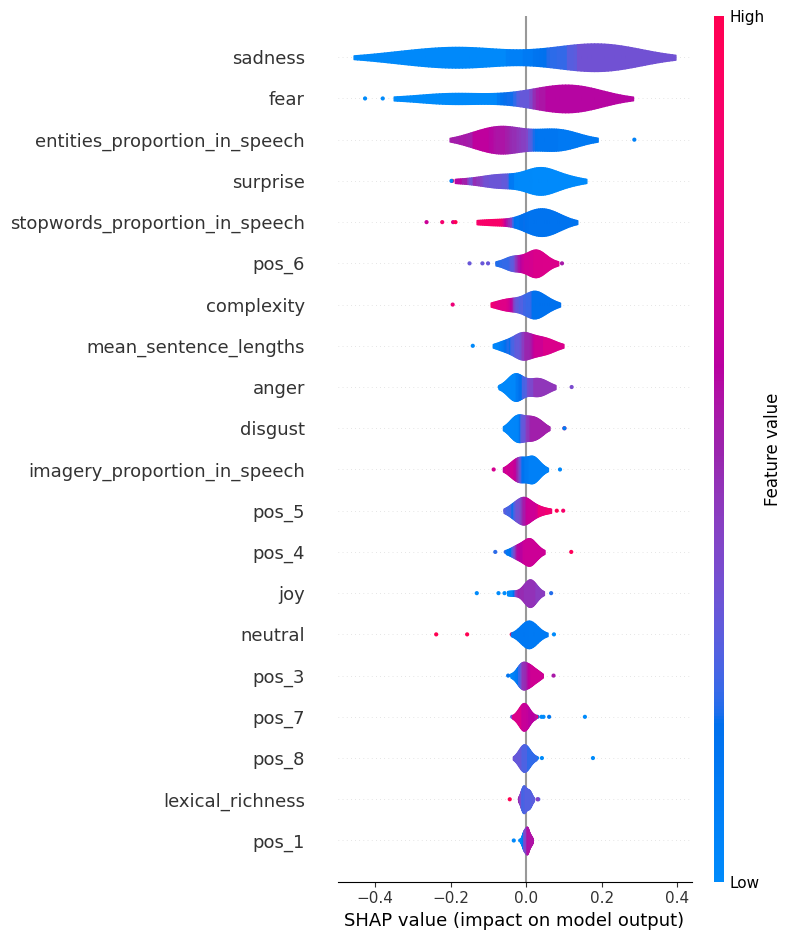

In [111]:
df_X_train_scaled = pd.DataFrame(X_train_scaled,columns=feature_names)
df_X_test_scaled = pd.DataFrame(X_test_scaled,columns=feature_names)
explainer = shap.Explainer(model.predict, df_X_test_scaled)
shap_values = explainer(df_X_test_scaled)
shap.summary_plot(shap_values, plot_type='violin')